  ---

  ### T-Period Family Model with Human Capital Investment

  Solves a $T$-period dynamic model where a family makes decisions over consumption, labor supply, child care time, and education expenditure to maximize lifetime utility. The utility function incorporates consumption, leisure, and the child's human capital, reflecting preferences over these elements and investment in the child's future human capital.

  #### Model Description

  The model is solved backwards from period $T$ to period 1. At each period $t = 1, \dots, T-1$, the family chooses:

  - **Consumption** $c_t > 0$
  - **Education expenditure** $e_t > 0$
  - **Labor supply** $h_t \in [0, 1]$
  - **Child care time** $t_t \in [0, 1]$

  to maximize the value function:

  $$
  V_t(a_t, k_t, z_t) = \max_{c_t, e_t, h_t, t_t} \left\{ \phi_3 \log c_t + \phi_1 \log (1 - h_t - t_t) + \phi_2 \log z_t + \beta V_{t+1}(a_{t+1}, k_{t+1}, z_{t+1}) \right\}
  $$

  subject to the following constraints:

  - **Budget constraint**:
    $$
    a_{t+1} = (1 + r) a_t + w_t h_t + y - c_t - e_t \geq a_{\min}
    $$
  - **Human capital accumulation for parents**:
    $$
    k_{t+1} = k_t + h_t
    $$
  - **Human capital technology**:
    $$
    z_{t+1} = \log R + \sigma_1 \log t_t + \sigma_2 \log e_t + \sigma_3 \log z_t
    $$
  - **Time constraint**:
    $$
    h_t + t_t \leq 0.8
    $$

  where:
  - $a_t$: Assets at the beginning of period $t$
  - $k_t$: human capital for parents (cumulative labor supply)
  - $z_t$: child's human capital
  - $w_t$: Wage rate per unit of labor
  - $y$: Unearned income
  - $r$: Interest rate
  - $\beta$: Discount factor


  ---

  ### Model Parameter Settings

  The following table lists the model parameters, their default values, and descriptions, as defined in the `FamilyModel` constructor:

  | **Parameter**   | **Value**       | **Description**                                      |
  |------------------|-----------------|------------------------------------------------------|
  | `T`              | 10              | Number of periods                                    |
  | `β` (`beta`)     | 0.97            | Discount factor                                      |
  | `φ_1` (`phi_1`)  | 0.25            | Utility from consumption                             |
  | `φ_2` (`phi_2`)  | 0.25            | Disutility of labor and child care (leisure weight)  |
  | `φ_3` (`phi_3`)  | 0.5             | Utility from log human capital                       |
  | `R`              | 1.0             | Human capital technology scale parameter             |
  | `σ_1` (`sigma_1`)| 0.2             | Elasticity of human capital w.r.t. child care time   |
  | `σ_2` (`sigma_2`)| 0.1             | Elasticity of human capital w.r.t. education expenditure |
  | `σ_3` (`sigma_3`)| 0.7             | Elasticity of human capital w.r.t. current human capital |
  | `τ` (`tau`)      | 0.25            | Labor income tax rate                                |
  | `r`              | 0.03            | Interest rate                                        |
  | `y`              | 0.0          | Unearned income per period                           |
  | `ψ` (`psi_terminal`) | 4.0         | Weight on terminal log human capital                 |
  | `w_base`         | 12.5            | Base wage rate per period (before tax and scaling)   |
  | `a_min`          | 0.0            | Minimum asset level                                  |
  | `a_max`          | 1e5             | Maximum asset level (scaled by /10000)                                |
  | `Na`             | 50              | Number of asset grid points                          |
  | `k_min`          | 0.0           | Minimum physical capital                             |
  | `k_max`          | 30.0            | Maximum physical capital                             |
  | `Nk`             | 50              | Number of physical capital grid points               |
  | `z_min`          | 1.0             | Minimum log human capital                            |
  | `z_max`          | 30.0            | Maximum log human capital                            |
  | `Nhc`            | 50              | Number of log human capital grid points              |



---

### Pseudo-Algorithm

The following outlines the steps for solving the model using value function iteration and simulating agent behavior over time.

#### Backward Induction

**Input:** Parameter set, grids for $a$, $k$, and $z$, terminal condition $V_T$

**For** $t = T$ to $1$ (backward):
1. **For each grid point** $(a_t, k_t, z_t)$:
    - Define bounds for $(c_t, e_t, h_t, t_t)$
    - Set constraints:
    - Use NLopt with `LD_SLSQP` to solve:
      $$
      \max \left\{ \phi_3 \log c_t + \phi_1 \log(1 - h_t - t_t) + \phi_2 \log z_t + \beta V_{t+1}(a_{t+1}, k_{t+1}, z_{t+1}) \right\}
      $$
    - Interpolate $V_{t+1}$ as needed
    - Store optimal $(c_t, e_t, h_t, t_t)$ and $V_t(a_t, k_t, z_t)$

**Output:** Value and policy functions over all state combinations

#### Simulation

**Input:** Initial states $(a_0, k_0, z_0)$ for $N$ agents

**For each agent** $i = 1$ to $N$:
1. Initialize $(a_1^i, k_1^i, z_1^i)$ from user-defined inputs
2. **For** $t = 1$ to $T$:
    - Interpolate policy functions at current state $(a_t^i, k_t^i, z_t^i)$ to get $(c_t, e_t, h_t, t_t)$
    - Update:
      - $a_{t+1}^i = (1 + r) a_t^i + w_t h_t - c_t - e_t$
      - $k_{t+1}^i = k_t^i + h_t$
      - $z_{t+1}^i = \log R + \sigma_1 \log t_t + \sigma_2 \log e_t + \sigma_3 \log z_t$
3. Store time paths for all decision and state variables

**Output:** Time series for $(c_t, h_t, t_t, e_t, a_t, k_t, z_t)$ for all agents

> **Note:**  
> The optimization in each step is performed using the `LD_SLSQP` algorithm from the NLopt library. `LD_SLSQP` (Sequential Least Squares Quadratic Programming) is a gradient-based solver that efficiently handles nonlinear objectives and constraints with variable bounds. Its use of gradients enables fast and accurate convergence, making it well-suited for dynamic programming models with complex economic constraints—such as minimum leisure or budget feasibility—ensuring that computed policies are feasible and optimal given the model structure.

In [267]:
using Random, NLopt, LinearAlgebra, Interpolations, Base.Threads, DataFrames
using Plots, Statistics, ProgressMeter, ForwardDiff, Distributions, Profile
using DataFrames, Measures, StatsBase, LaTeXStrings, Printf, ForwardDiff
using StaticArrays: SVector

In [352]:
# -------------------------------
# Utility: Nonlinear Grid Creator
# -------------------------------
function nonlinspace(start::Float64, stop::Float64, num::Int, curv::Float64)
    lin_vals = range(0, stop=1, length=num)
    curved_vals = lin_vals .^ curv
    return start .+ (stop - start) .* curved_vals
end

function create_focused_grid(a_min::Float64, a_focus::Float64, a_max::Float64, Na::Int, focus_share::Float64, curv::Float64)
    Na_focus = ceil(Int, Na * focus_share)
    Na_rest = Na - Na_focus
    grid_focus = nonlinspace(a_min, a_focus, Na_focus, curv)
    grid_rest = nonlinspace(a_focus, a_max, Na_rest + 1, curv)[2:end]
    return vcat(grid_focus, grid_rest)
end

# -------------------------------
# Dynamic Family Model Definition
# -------------------------------
using Random

mutable struct FamilyModel
    # --- Model Parameters ---
    T::Int                        # Number of periods
    beta::Float64                 # Discount factor
    phi_1::Float64                # Parent's disutility of labor
    phi_2::Float64                # Parent's utility from human capital
    phi_3::Float64                # Parent's utility from consumption
    R::Float64                    # Human capital technology parameter
    sigma_1::Float64              # Elasticity: HC w.r.t. child care time
    sigma_2::Float64              # Elasticity: HC w.r.t. investment
    sigma_3::Float64              # Elasticity: HC w.r.t. current human capital
    tau::Float64                  # Labor income tax
    r::Float64                    # Interest rate
    y::Float64                    # Unearned income
    a_max::Float64                # Max asset level
    a_min::Float64                # Min asset level
    Na::Int                       # Asset grid size
    k_max::Float64                # Max physical capital
    k_min::Float64                # Min physical capital
    Nk::Int                       # Physical capital grid size
    hc_max::Float64               # Max human capital (for child/parent)
    hc_min::Float64               # Min human capital
    Nhc::Int                      # Human capital grid size
    alpha::Float64                # Parameter in wage function
    psi_terminal::Float64         # importance of terminal HC

    # --- Grids ---
    a_grid::Vector{Float64}       # Asset grid
    k_grid::Vector{Float64}       # Physical capital grid
    hc_grid::Vector{Float64}      # Human capital grid

    # --- Solution Arrays (for value function iteration) ---
    sol_c::Array{Float64,4}       # Parental consumption    [T, Na, Nk, Nhc]
    sol_h::Array{Float64,4}       # Parental labor supply   [T, Na, Nk, Nhc]
    sol_t::Array{Float64,4}       # Child care time         [T, Na, Nk, Nhc]
    sol_e::Array{Float64,4}       # Education expenditure   [T, Na, Nk, Nhc]
    sol_v::Array{Float64,4}       # Value function          [T, Na, Nk, Nhc]

    # --- Simulation Storage ---
    simN::Int                     # Number of simulated agents
    simT::Int                     # Number of simulation periods
    sim_c::Array{Float64,2}       # Simulated consumption   [simN, simT]
    sim_h::Array{Float64,2}       # Simulated labor         [simN, simT]
    sim_t::Array{Float64,2}       # Simulated child care    [simN, simT]
    sim_e::Array{Float64,2}       # Simulated education exp [simN, simT]
    sim_a::Array{Float64,2}       # Simulated assets        [simN, simT]
    sim_k::Array{Float64,2}       # Simulated capital       [simN, simT]
    sim_hc::Array{Float64,2}      # Simulated human capital [simN, simT]
    sim_wage::Array{Float64,2}     # Simulated wage         [simN, simT]
    sim_income::Array{Float64,2}   # Simulated income       [simN, simT]


    # --- Initial conditions ---
    sim_a_init::Vector{Float64}   # Initial assets          [simN]
    sim_k_init::Vector{Float64}   # Initial capital         [simN]
    sim_hc_init::Vector{Float64}  # Initial human capital   [simN]

    # --- Wage vector (for each period) ---
    w_vec::Vector{Float64}        # Wage per period         [T]
end

function FamilyModel(; T::Int=10, beta::Float64=0.97,
                        phi_1::Float64=0.25, phi_2::Float64=0.25, phi_3::Float64=0.5,
                        R::Float64=2.0, sigma_1::Float64=0.2,
                        sigma_2::Float64=0.1, sigma_3::Float64=0.7,
                        tau::Float64=0.25, r::Float64=0.03,
                        y::Float64=0.0, a_max::Float64=10.0,
                        a_min::Float64=0.0, Na::Int=30, psi_terminal::Float64=2.0,
                        k_max::Float64=10.0, k_min::Float64=0.0, Nk::Int=30,
                        hc_max::Float64=10.0, hc_min::Float64=1.0, Nhc::Int=30,
                        simN::Int=5000, simT::Int=T, alpha::Float64=0.08, seed::Int=1234)



    # Grids (custom grid functions)
    a_grid = create_focused_grid(a_min, 5.0, a_max, Na, 0.8, 1.2)
    #a_grid = nonlinspace(a_min, a_max, Na, 1.2)
    #k_grid = nonlinspace(k_min, k_max, Nk, 1.2)
    k_grid = create_focused_grid(k_min, 3.0, k_max, Nk, 0.8, 1.2)
    hc_grid = create_focused_grid(hc_min, 3.0, hc_max, Nhc, 0.8, 1.2)

    # Solution arrays (4D: [T, Na, Nk, Nhc])
    sol_shape = (T, Na, Nk, Nhc)
    sol_c = fill(NaN, sol_shape)
    sol_h = fill(NaN, sol_shape)
    sol_t = fill(NaN, sol_shape)
    sol_e = fill(NaN, sol_shape)
    sol_v = fill(NaN, sol_shape)

    # Simulation arrays (2D: [simN, simT])
    sim_shape = (simN, simT)
    sim_c = fill(NaN, sim_shape)
    sim_h = fill(NaN, sim_shape)
    sim_t = fill(NaN, sim_shape)
    sim_e = fill(NaN, sim_shape)
    sim_a = fill(NaN, sim_shape)
    sim_k = fill(NaN, sim_shape)
    sim_hc = fill(NaN, sim_shape)
    sim_wage = fill(NaN, sim_shape)
    sim_income = fill(NaN, sim_shape)

    # Initial conditions
    sim_a_init = zeros(Float64, simN)
    sim_k_init = fill(k_min, simN)
    sim_hc_init = fill(hc_min, simN)

    # Wage vector
    w_vec = fill(12.5, T)

    return FamilyModel(T, beta, phi_1, phi_2, phi_3, R, sigma_1, sigma_2, sigma_3,
                      tau, r, y, a_max, a_min, Na, k_max, k_min, Nk, hc_max, hc_min, Nhc, alpha, psi_terminal,
                      a_grid, k_grid, hc_grid,
                      sol_c, sol_h, sol_t, sol_e, sol_v,
                      simN, simT, sim_c, sim_h, sim_t, sim_e, sim_a, sim_k, sim_hc, sim_wage, sim_income,
                      sim_a_init, sim_k_init, sim_hc_init,
                      w_vec)
end

FamilyModel

In [353]:
  # --------------------------
    # Model Solver with Gradient-Based Optimization
    # --------------------------
    function solve_model!(model::FamilyModel)
        T, Na, Nk, Nhc = model.T, model.Na, model.Nk, model.Nhc
        a_grid, k_grid, hc_grid = model.a_grid, model.k_grid, model.hc_grid

        # Last period (t = T)
        for i_a in 1:Na
            for i_k in 1:Nk
                for i_hc in 1:Nhc
                    assets = a_grid[i_a]
                    capital = k_grid[i_k]
                    HC = hc_grid[i_hc]

                    # Objective wrapper for NLopt with gradients
                    function obj_wrapper(x::Vector, grad::Vector)
                        e_p, h_p, t_p = x[1], x[2], x[3]
                        f = obj_last_period(model, e_p, h_p, t_p, assets, HC, capital, T, grad)
                        if length(grad) > 0
                            grad[:] = -grad[:]  # NLopt minimizes, so gradient is -∇f
                        end
                        return -f  # Return negative for minimization
                    end

                    opt = Opt(:LD_SLSQP, 3)
                    lower_bounds!(opt, [1e-6, 0.0, 0.0])  # e_p > 0, h_p ≥ 0, t_p ≥ 0
                    upper_bounds!(opt, [Inf, 1.0, 1.0])   # h_p ≤ 1, t_p ≤ 1
                    inequality_constraint!(opt, constraint_min_leisure, 1e-4)
                    min_objective!(opt, obj_wrapper)
                    init = [1.0, 0.4, 0.4]  # Initial guess
                    ftol_rel!(opt, 1e-8)
                    maxeval!(opt, 10000)
                    (minf, x_opt, ret) = optimize(opt, init)

                    # Store solutions
                    model.sol_e[T, i_a, i_k, i_hc] = x_opt[1]
                    model.sol_h[T, i_a, i_k, i_hc] = x_opt[2]
                    model.sol_t[T, i_a, i_k, i_hc] = x_opt[3]
                    model.sol_c[T, i_a, i_k, i_hc] = assets + wage_func(model, k_grid[i_k], T) * x_opt[2] + model.y - x_opt[1]
                    model.sol_v[T, i_a, i_k, i_hc] = -minf
                end
            end
        end

        # Earlier periods (t = T-1 to 1)
        for t in (T-1):-1:1
            println("Solving period $t ...")
            interp = create_interp(model, model.sol_v, t+1)

            for i_a in 1:Na
                for i_k in 1:Nk
                    for i_hc in 1:Nhc
                        assets = a_grid[i_a]
                        capital = k_grid[i_k]
                        HC = hc_grid[i_hc]

                        # Objective wrapper with gradients
                        function obj_wrapper(x::Vector, grad::Vector)
                            c_p, e_p, h_p, t_p = x[1], x[2], x[3], x[4]
                            f = obj_work_period(model, c_p, e_p, h_p, t_p, assets, HC, capital, t, interp, grad)
                            if length(grad) > 0
                                grad[:] = -grad[:]  # Gradient for minimization
                            end
                            return -f
                        end

                        function asset_constraint(x::Vector, grad::Vector)
                            c_p, e_p, h_p = x[1], x[2], x[3]
                            w = wage_func(model, capital, t)
                            a_next = (1.0 + model.r) * assets + w * h_p + model.y - c_p - e_p
                            if length(grad) > 0
                                grad[1] = 1.0   # ∂g/∂c_p
                                grad[2] = 1.0   # ∂g/∂e_p
                                grad[3] = -w    # ∂g/∂h_p
                                grad[4] = 0.0   # ∂g/∂t_p
                            end
                            return model.a_min - a_next  # g(x) ≤ 0
                        end

                        opt = Opt(:LD_SLSQP, 4)
                        lower_bounds!(opt, [1e-6, 0.0, 0.0, 0.0])
                        upper_bounds!(opt, [Inf, Inf, 1.0, 1.0])
                        inequality_constraint!(opt, constraint_min_leisure, 1e-4)
                        inequality_constraint!(opt, asset_constraint, 1e-4)
                        min_objective!(opt, obj_wrapper)
                        
                        init = [model.sol_c[t+1, i_a, i_k, i_hc],
                                model.sol_e[t+1, i_a, i_k, i_hc],
                                min(model.sol_h[t+1, i_a, i_k, i_hc], 0.5),
                               min(model.sol_t[t+1, i_a, i_k, i_hc], 0.5)]

                        #init = [0.2, 0.4, 0.4]

                        ftol_rel!(opt, 1e-8)
                        maxeval!(opt, 10000)
                        (minf, x_opt, ret) = optimize(opt, init)

                        # Store solutions
                        model.sol_c[t, i_a, i_k, i_hc] = x_opt[1]
                        model.sol_e[t, i_a, i_k, i_hc] = x_opt[2]
                        model.sol_h[t, i_a, i_k, i_hc] = x_opt[3]
                        model.sol_t[t, i_a, i_k, i_hc] = x_opt[4]
                        model.sol_v[t, i_a, i_k, i_hc] = -minf
                    end
                end
            end
        end
    end

  
  
  
  
  # ------------------------------------------------
    # Supporting Functions with Gradients
    # ------------------------------------------------
    function obj_last_period(
        model::FamilyModel, e_p::Float64, h_p::Float64, t_p::Float64,
        assets::Float64, log_HC::Float64, capital::Float64, t::Int, grad::Vector
    )
        w = wage_func(model, capital, t)
        c = assets + w * h_p + model.y - e_p
        leisure = 1.0 - h_p - t_p
        log_HC_next = HC_technology(model, t_p, e_p, log_HC)
        util_now = util_parent(model, c, h_p, t_p, log_HC)
        terminal = terminal_value(model, log_HC_next)

        if length(grad) > 0
            # Gradients of log_HC_next
            dlogHC_de = model.sigma_2 / e_p
            dlogHC_dt = model.sigma_1 / t_p
            
            # ∂f/∂e_p = ∂u/∂c * ∂c/∂e_p + ∂terminal/∂log_HC_next * ∂log_HC_next/∂e_p
            grad[1] = -model.phi_1 / c + model.psi_terminal * dlogHC_de
            # ∂f/∂h_p = ∂u/∂c * ∂c/∂h_p + ∂u/∂leisure * ∂leisure/∂h_p
            grad[2] = model.phi_1 * w / c - model.phi_2 / leisure
            # ∂f/∂t_p = ∂u/∂leisure * ∂leisure/∂t_p + ∂terminal/∂log_HC_next * ∂log_HC_next/∂t_p
            grad[3] = -model.phi_2 / leisure + model.psi_terminal * dlogHC_dt
        end

        return util_now + terminal
    end

    function obj_work_period(
        model::FamilyModel, c_p::Float64, e_p::Float64, h_p::Float64, t_p::Float64,
        assets::Float64, log_HC::Float64, capital::Float64, t::Int, interp, grad::Vector
    )
        w = wage_func(model, capital, t)
        income = w * h_p
        a_next = (1.0 + model.r) * assets + income + model.y - c_p - e_p
        k_next = capital + h_p
        log_HC_next = HC_technology(model, t_p, e_p, log_HC)
        leisure = 1.0 - h_p - t_p
        util_now = util_parent(model, c_p, h_p, t_p, log_HC)
        V_next = interp(a_next, k_next, log_HC_next)

        if length(grad) > 0
            ∇V_next = gradient(interp, a_next, k_next, log_HC_next)
            ∂V_∂a, ∂V_∂k, ∂V_∂logHC = ∇V_next
            dlogHC_de = model.sigma_2 / e_p
            dlogHC_dt = model.sigma_1 / t_p

            grad[1] = model.phi_1 / c_p - model.beta * ∂V_∂a                # ∂f/∂c_p
            grad[2] = model.beta * (-∂V_∂a + ∂V_∂logHC * dlogHC_de)        # ∂f/∂e_p
            grad[3] = -model.phi_2 / leisure + model.beta * (w * ∂V_∂a + ∂V_∂k)  # ∂f/∂h_p
            grad[4] = -model.phi_2 / leisure + model.beta * ∂V_∂logHC * dlogHC_dt  # ∂f/∂t_p
        end

        return util_now + model.beta * V_next
    end

    # Existing supporting functions (assumed unchanged unless specified)
    @inline function util_parent(model::FamilyModel, c::Float64, h_p::Float64, t_p::Float64, log_HC::Float64)
        leisure = 1.0 - h_p - t_p
        if leisure <= 0.0 || c <= 0.0
            return -Inf
        end
        return model.phi_1 * log(c) + model.phi_2 * log(leisure) + model.phi_3 * log_HC
    end

    @inline function HC_technology(model::FamilyModel, t_p::Float64, e_p::Float64, log_HC::Float64)
        if t_p <= 0.0 || e_p <= 0.0
            return -Inf  # Ensure inputs are positive for logarithms
        end
        return log(model.R) + model.sigma_1 * log(t_p) + model.sigma_2 * log(e_p) + model.sigma_3 * log_HC
    end

    @inline function terminal_value(model::FamilyModel, log_HC_next::Float64)
        return model.psi_terminal * log_HC_next
        #x = 20.0
        #return x
    end

    @inline function wage_func(model::FamilyModel, capital::Float64, t::Int)
        return (1 - model.tau) * model.w_vec[t] * (1.0 + model.alpha * capital) * 0.584
    end

    function create_interp(model::FamilyModel, sol_v, t)
        itp = interpolate(
            (model.a_grid, model.k_grid, model.hc_grid),
            sol_v[t, :, :, :],
            Gridded(Linear())
        )
        return extrapolate(itp, Line())
    end

    @inline function constraint_min_leisure(x::Vector, grad::Vector)
        n = length(x)
        h_p = x[n-1] # For last period: x=[e,h,t], n=3; x[2]=h. For work: x=[c,e,h,t], n=4; x[3]=h
        t_p = x[n]   # For last period: x[3]=t. For work: x[4]=t

        # leisure = 1.0 - h_p - t_p # Not needed for gradient calculation here
        # g(x) = h_p + t_p - 0.9
        if length(grad) > 0
            grad .= 0.0
            grad[n-1] = 1.0  # ∂g/∂h_p
            grad[n]   = 1.0  # ∂g/∂t_p
        end
        return (h_p + t_p) - 0.8 # constraint: h_p + t_p - 0.9 <= 0
    end

    # Asset constraint: a_next ≥ a_min


constraint_min_leisure (generic function with 1 method)

In [354]:
function simulate_model!(model::FamilyModel)
    simN, simT = model.simN, model.simT

    # For readability, alias the arrays
    sim_a, sim_k, sim_hc = model.sim_a, model.sim_k, model.sim_hc
    sim_c, sim_e, sim_h, sim_t = model.sim_c, model.sim_e, model.sim_h, model.sim_t
    sim_wage, sim_income = model.sim_wage, model.sim_income

    # Precompute 3D interpolators for each period and each decision
    interp_dict = Dict{Tuple{Int, Symbol}, Any}()
    for t in 1:simT
        interp_dict[(t, :c)] = LinearInterpolation((model.a_grid, model.k_grid, model.hc_grid), model.sol_c[t, :, :, :], extrapolation_bc=Line())
        interp_dict[(t, :e)] = LinearInterpolation((model.a_grid, model.k_grid, model.hc_grid), model.sol_e[t, :, :, :], extrapolation_bc=Line())
        interp_dict[(t, :h)] = LinearInterpolation((model.a_grid, model.k_grid, model.hc_grid), model.sol_h[t, :, :, :], extrapolation_bc=Line())
        interp_dict[(t, :t)] = LinearInterpolation((model.a_grid, model.k_grid, model.hc_grid), model.sol_t[t, :, :, :], extrapolation_bc=Line())
    end

    # Initialize starting conditions
    for i in 1:simN
        sim_a[i, 1]  = model.sim_a_init[i]
        sim_k[i, 1]  = model.sim_k_init[i]
        sim_hc[i, 1] = model.sim_hc_init[i]
    end

    # Simulation loop
    for i in 1:simN
        for t in 1:simT
            a = sim_a[i, t]
            k = sim_k[i, t]
            z = sim_hc[i, t]

            # Interpolate policies
            sim_c[i, t] = interp_dict[(t, :c)](a, k, z)
            sim_e[i, t] = interp_dict[(t, :e)](a, k, z)
            sim_h[i, t] = interp_dict[(t, :h)](a, k, z)
            sim_t[i, t] = interp_dict[(t, :t)](a, k, z)

            # Compute wage and income
            sim_wage[i, t] = wage_func(model, k, t) / 0.584
            sim_income[i, t] = wage_func(model, k, t) * sim_h[i, t]

            # Evolve state variables if not final period
            if t < simT
                sim_a[i, t+1]  = (1 + model.r) * a + wage_func(model, k, t) * sim_h[i, t] + model.y - sim_c[i, t] - sim_e[i, t]
                sim_k[i, t+1]  = k + sim_h[i, t]
                sim_hc[i, t+1] = log(model.R) + model.sigma_1 * log(sim_t[i, t]) +
                                 model.sigma_2 * log(sim_e[i, t]) + model.sigma_3 * z
            end
        end
    end
end

simulate_model! (generic function with 1 method)

In [355]:
model_baseline = FamilyModel()
solve_model!(model_baseline)
simulate_model!(model_baseline)

Solving period 9 ...
Solving period 8 ...
Solving period 7 ...
Solving period 6 ...
Solving period 5 ...
Solving period 4 ...
Solving period 3 ...
Solving period 2 ...
Solving period 1 ...


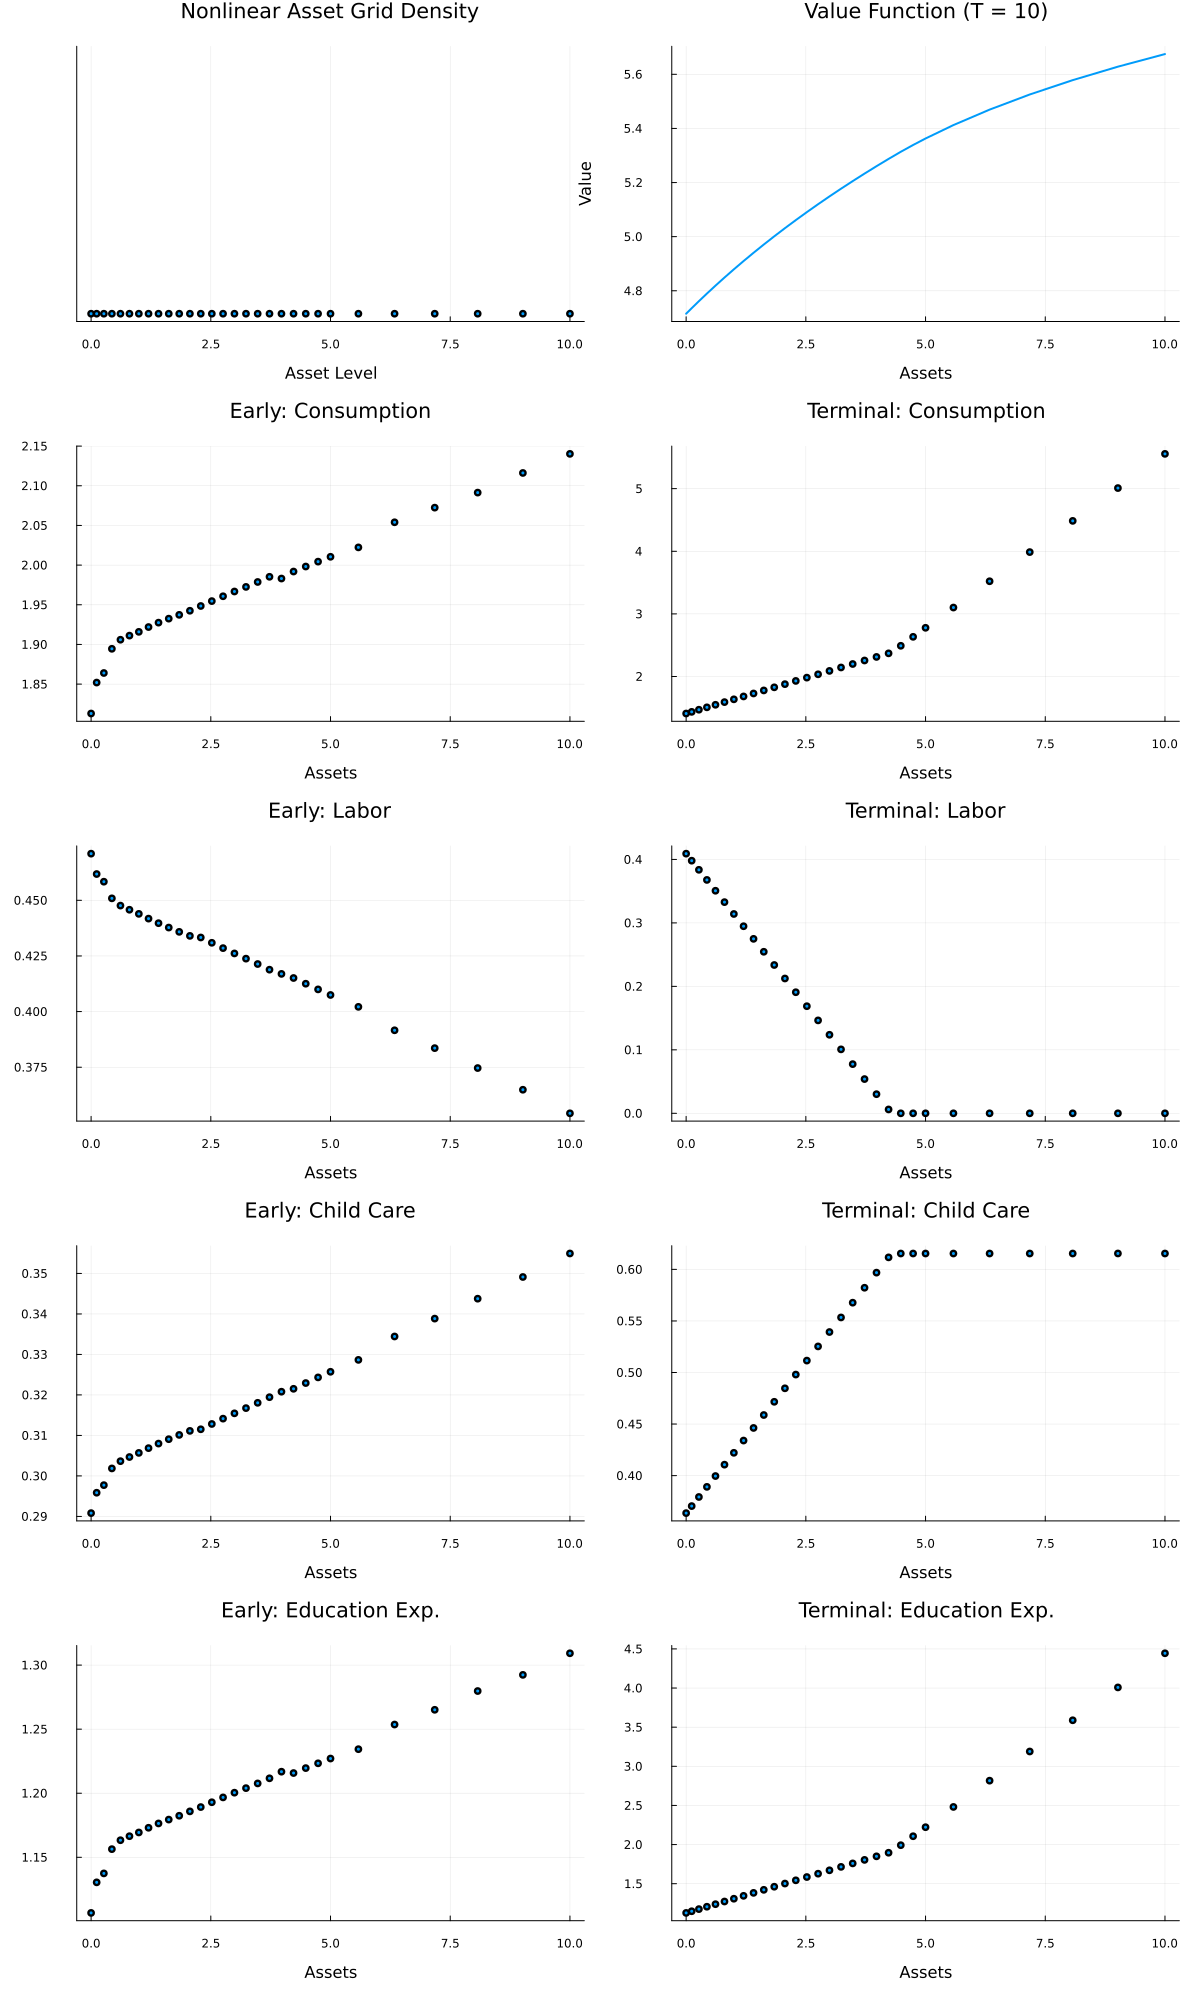

In [356]:
using Plots

# Indices
k_mid = Int(ceil(length(model_baseline.k_grid) / 2))
hc_mid = Int(ceil(length(model_baseline.hc_grid) / 2))
T_terminal = model_baseline.T
t_early = 1
a_grid = model_baseline.a_grid

# 1. Nonlinear asset grid (early/terminal concept doesn't apply—repeat for both columns)
p1 = scatter(model_baseline.a_grid, zeros(length(model_baseline.a_grid)),
    xlabel = "Asset Level",
    yticks = [],
    title = "Nonlinear Asset Grid Density",
    markersize = 3,
    legend = false)
    
p2 = plot(
    a_grid,
    model_baseline.sol_v[T_terminal, :, k_mid, hc_mid],
    xlabel = "Assets",
    ylabel = "Value",
    title = "Value Function (T = $(T_terminal))",
    label = "Vₜ(a)",
    linewidth = 2,
)

# 2. Consumption
p3 = scatter(
    a_grid, model_baseline.sol_c[t_early, :, k_mid, hc_mid],
    xlabel = "Assets", ylabel = "Consumption",
    title = "Early: Consumption", label = "cₜ(a)", markersize = 3)
p4 = scatter(
    a_grid, model_baseline.sol_c[T_terminal, :, k_mid, hc_mid],
    xlabel = "Assets", ylabel = "",
    title = "Terminal: Consumption", label = "cₜ(a)", markersize = 3)

# 3. Labor
p5 = scatter(
    a_grid, model_baseline.sol_h[t_early, :, k_mid, hc_mid],
    xlabel = "Assets", ylabel = "Labor",
    title = "Early: Labor", label = "hₜ(a)", markersize = 3)
p6 = scatter(
    a_grid, model_baseline.sol_h[T_terminal, :, k_mid, hc_mid],
    xlabel = "Assets", ylabel = "",
    title = "Terminal: Labor", label = "hₜ(a)", markersize = 3)

# 4. Child care time
p7 = scatter(
    a_grid, model_baseline.sol_t[t_early, :, k_mid, hc_mid],
    xlabel = "Assets", ylabel = "Child Care",
    title = "Early: Child Care", label = "tₜ(a)", markersize = 3)
p8 = scatter(
    a_grid, model_baseline.sol_t[T_terminal, :, k_mid, hc_mid],
    xlabel = "Assets", ylabel = "",
    title = "Terminal: Child Care", label = "tₜ(a)", markersize = 3)

# 5. Education expenditure
p9 = scatter(
    a_grid, model_baseline.sol_e[t_early, :, k_mid, hc_mid],
    xlabel = "Assets", ylabel = "Education Exp.",
    title = "Early: Education Exp.", label = "eₜ(a)", markersize = 3)
    
p10 = scatter(
    a_grid, model_baseline.sol_e[T_terminal, :, k_mid, hc_mid],
    xlabel = "Assets", ylabel = "",
    title = "Terminal: Education Exp.", label = "eₜ(a)", markersize = 3)

# Combine all plots into a 5×2 grid
plot(
    p1, p2,
    p3, p4,
    p5, p6,
    p7, p8,
    p9, p10,
    layout = (5, 2),
    size = (1200, 2000),
    margin = 3mm,
    legend = false
)

In [357]:
t = 1:model_baseline.simT

function extract_all(model)
    return (
        c = mean(model.sim_c, dims=1)[:],
        a = mean(model.sim_a, dims=1)[:],
        h = mean(model.sim_h, dims=1)[:],
        k = mean(model.sim_k, dims=1)[:],
        t = mean(model.sim_t, dims=1)[:],
        e = mean(model.sim_e, dims=1)[:],
        hc = mean(model.sim_hc, dims=1)[:],
        income = mean(model.sim_income, dims=1)[:],
        wage = mean(model.sim_wage, dims=1)[:]
    )
end

extract_all (generic function with 1 method)

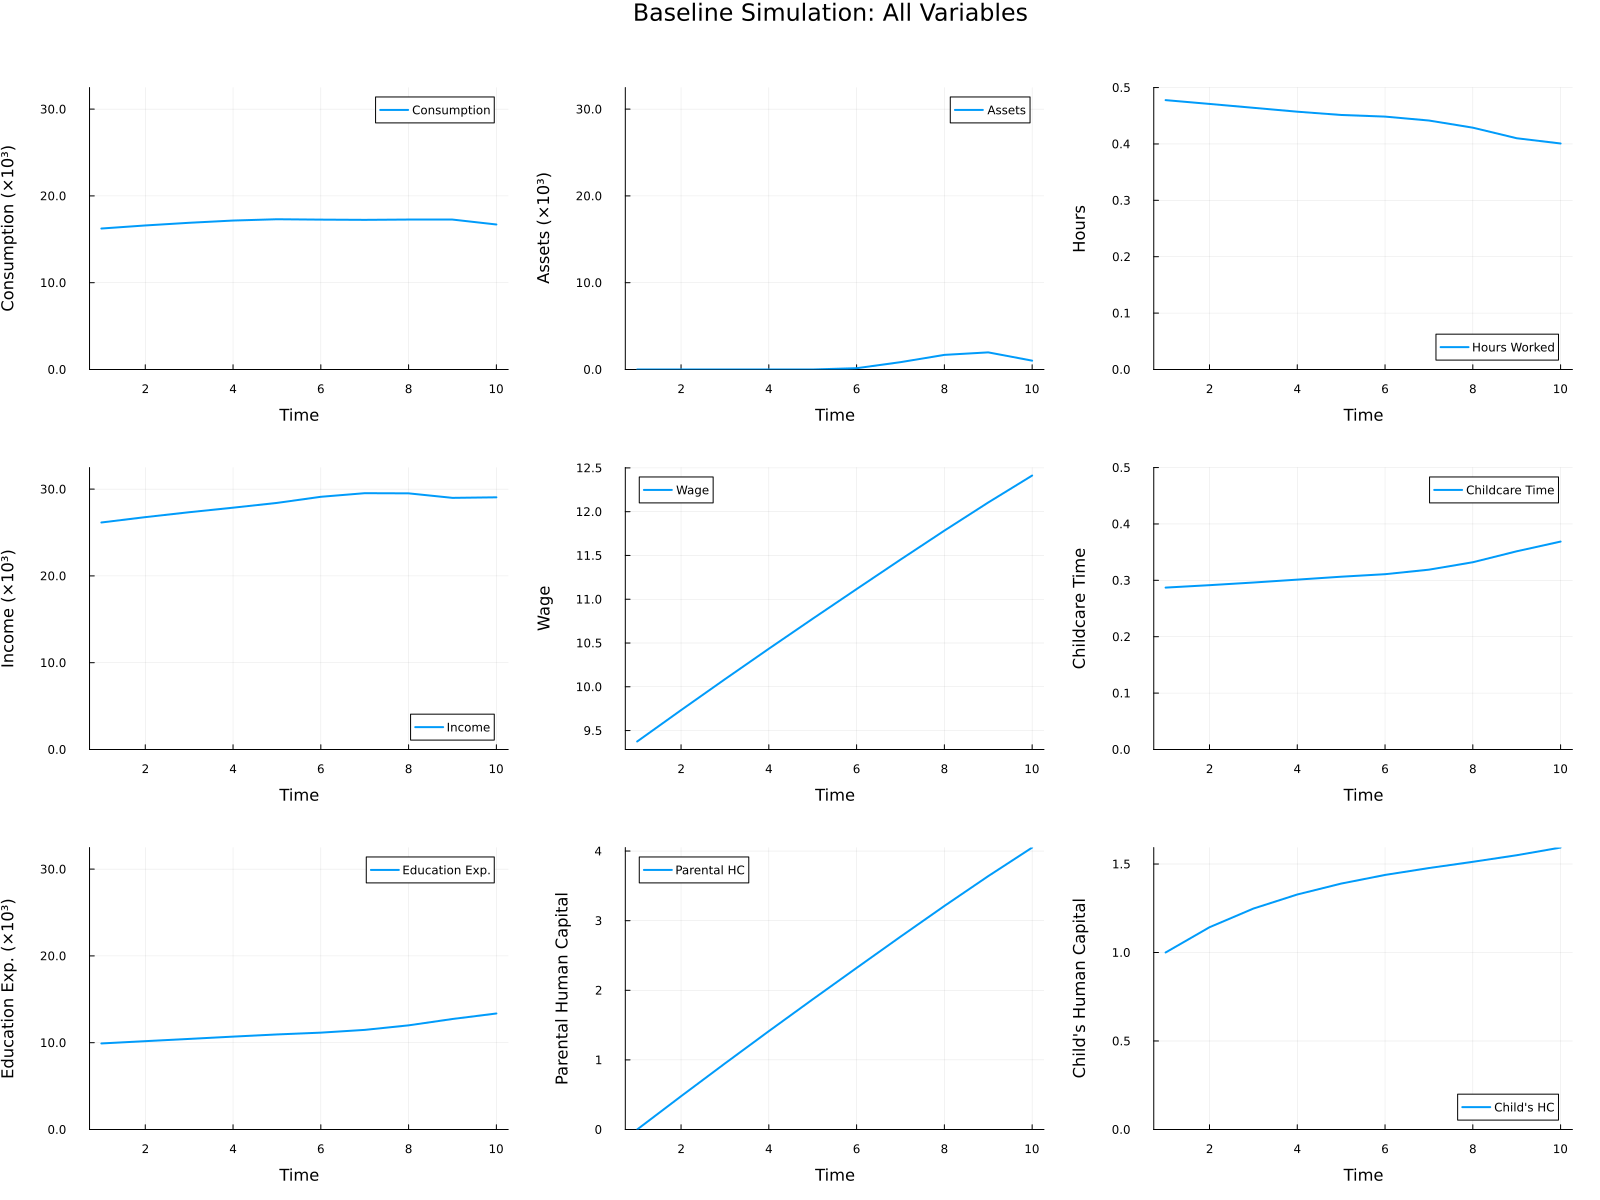

In [ ]:
# Extract data
base = extract_all(model_baseline)

c_plot      = base.c .* 10
a_plot      = base.a .* 10
income_plot = base.income .* 10
e_plot      = base.e .* 10


# Time vector based on the length of the consumption array
t = 1:length(base.c)

ymax_c = maximum(vcat(base.c, base.a, base.income)) * 11
ymax_a      = maximum(vcat(base.c, base.a, base.income)) * 11
ymax_income = maximum(base.income) * 11
ymax_wage   = maximum(base.wage)
ymax_e      = maximum(vcat(base.c, base.a, base.income)) * 11
ymax_hc     = maximum(base.hc)
ymax_k      = maximum(base.k)
ymax_h      = maximum(vcat(base.h, base.t))
ymax_t      = maximum(base.t)

thousand_formatter2(y) = string(round(y; digits=2))

p1 = plot(t, c_plot, label="Consumption", lw=2, xlabel="Time", ylabel="Consumption (×10³)",
          yformatter=thousand_formatter2, ylim=(0, ymax_c))

p2 = plot(t, a_plot, label="Assets", lw=2, xlabel="Time", ylabel="Assets (×10³)",
          yformatter=thousand_formatter2, ylim=(0, ymax_a))

p3 = plot(t, base.h, label="Hours Worked", lw=2, xlabel="Time", ylabel="Hours", ylim=(0, 0.5))

p4 = plot(t, base.k, label="Parental HC", lw=2, xlabel="Time", ylabel="Parental Human Capital", ylim=(0, ymax_k))

p5 = plot(t, e_plot, label="Education Exp.", lw=2, xlabel="Time", ylabel="Education Exp. (×10³)",
          yformatter=thousand_formatter2, ylim=(0, ymax_e))

p6 = plot(t, base.hc, label="Child's HC", lw=2, xlabel="Time", ylabel="Child's Human Capital", ylim=(0, ymax_hc))

p7 = plot(t, base.t, label="Childcare Time", lw=2, xlabel="Time", ylabel="Childcare Time", ylim=(0, 0.5))

p8 = plot(t, income_plot, label="Income", lw=2, xlabel="Time", ylabel="Income (×10³)",
          yformatter=thousand_formatter2, ylim=(0, ymax_income))

p9 = plot(t, base.wage, label="Wage", lw=2, xlabel="Time", ylabel="Wage")

# For the others (like hours, human capital, etc.), add ylim as needed:


combined_plot = plot(p1, p2, p3, p8, p9, p7, p5, p4, p6,
                     layout=(3, 3),
                     size=(1600, 1200),
                     plot_title="Baseline Simulation: All Variables",
                     titlefont=16,
                     margin=5mm)

display(combined_plot)

Code for debuging

In [ ]:
for t in 1:model_baseline.T
    println("sum V at t=$t: ", sum(model_baseline.sol_v[t, :, :, :]))
    println("t=$t, first c: ", model_baseline.sol_c[t, 1, 1, 1])
end
model_baseline.sol_v

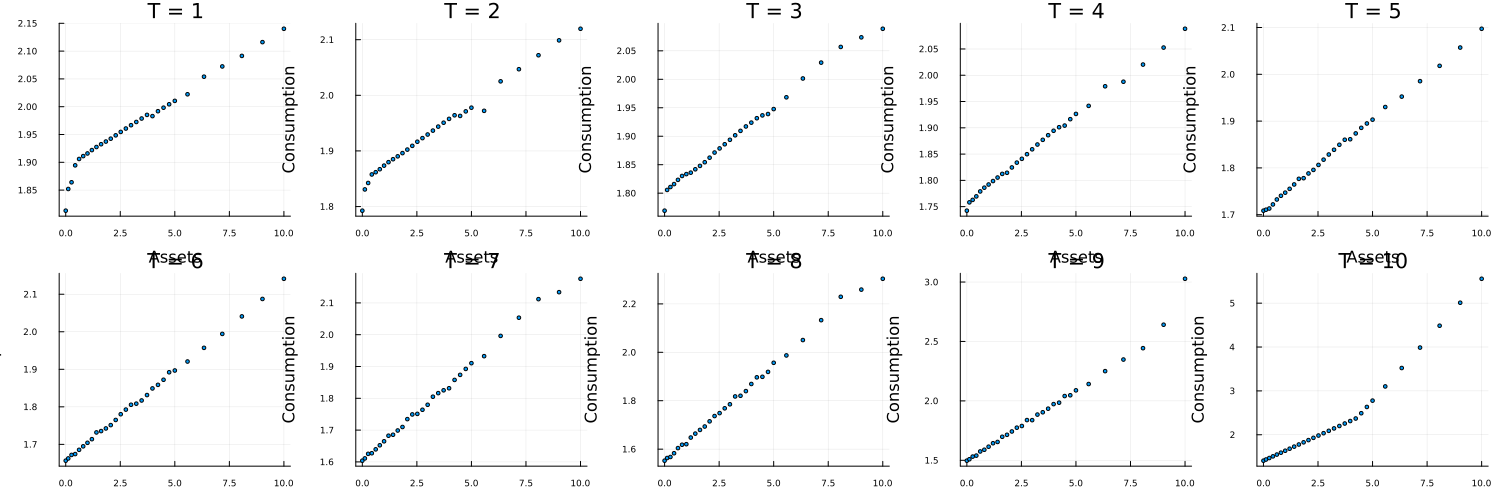

In [370]:
# visiualize the labor supply policy function for all the periods to see how it changes over time
gr()  # or your preferred backend

a_grid = model_baseline.a_grid
sol_h = model_baseline.sol_c
T = model_baseline.T
k_mid = Int(ceil(length(model_baseline.k_grid) / 2))  # pick a representative labor/skill state
hc_mid = Int(ceil(length(model_baseline.hc_grid) / 2))
plots = []

for t in 1:T
    p = scatter(a_grid, sol_h[t, :, k_mid, hc_mid],
        xlabel = "Assets",
        ylabel = "Consumption",
        title = "T = $t",
        label = false,
        markersize = 2,
        tickfontsize=6)
    push!(plots, p)
end

# Layout: adjust number of columns depending on how many you want per row
ncols = 5
plot(plots..., layout = (ceil(Int, T / ncols), ncols), size = (300 * ncols, 250 * ceil(Int, T / ncols)))

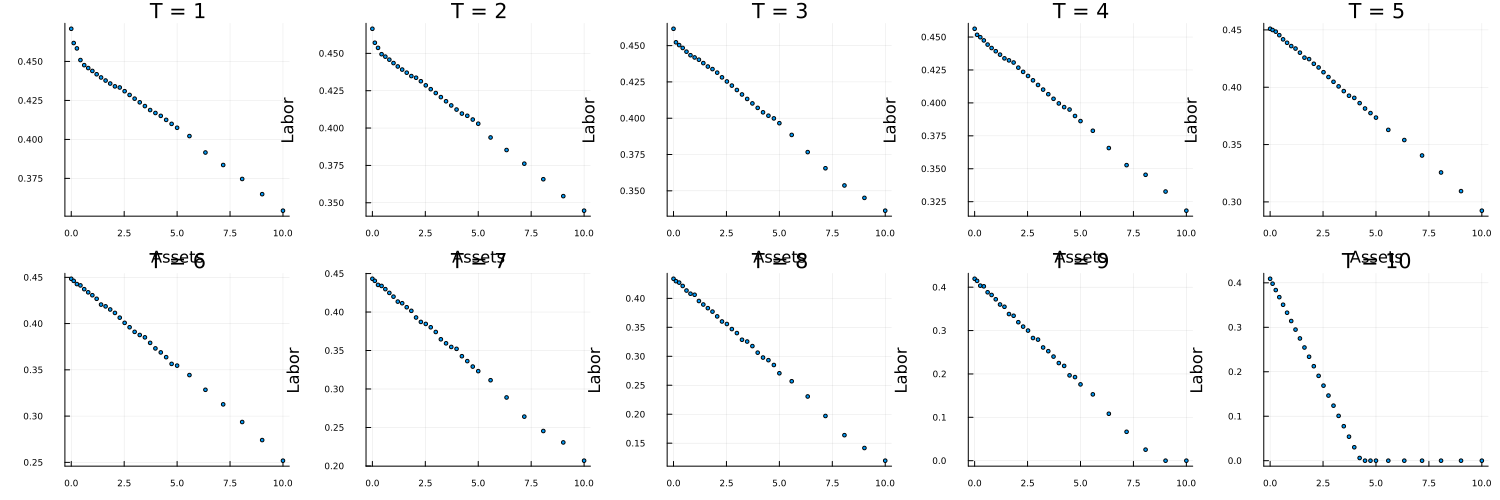

In [372]:
# visiualize the labor supply policy function for all the periods to see how it changes over time
gr()  # or your preferred backend

a_grid = model_baseline.a_grid
sol_h = model_baseline.sol_h
T = model_baseline.T
k_mid = Int(ceil(length(model_baseline.k_grid) / 2))  # pick a representative labor/skill state
hc_mid = Int(ceil(length(model_baseline.hc_grid) / 2))
plots = []

for t in 1:T
    p = scatter(a_grid, sol_h[t, :, k_mid, hc_mid],
        xlabel = "Assets",
        ylabel = "Labor",
        title = "T = $t",
        label = false,
        markersize = 2,
        tickfontsize=6)
    push!(plots, p)
end

# Layout: adjust number of columns depending on how many you want per row
ncols = 5
plot(plots..., layout = (ceil(Int, T / ncols), ncols), size = (300 * ncols, 250 * ceil(Int, T / ncols)))